# Problem setup

we will solve SEIR model with following parameter using PINN.

Population : 100,000 \
Pre-infectious period : 8 days \
infectious period : 7 days \
R0 : 13 \
Initial value : (S,E,I,R) = (99999 ,0 ,1 ,0)



 


$$\left\{
\begin{array}{ll}
\ dSdt = - \lambda * S   \\
\ dEdt =   \lambda * S  - f * E \\
\ dIdt =   f * E - r * I\\
\ dRdt =   r * I
\end{array}
\right.
$$

where $ \lambda = beta * I $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import odeint
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#Data generation

def sir(x,t,r,f,lamb):
    n=100000
    RN = 13
    beta = RN/(n*8)
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    lamb = beta * I
    dSdt = -lamb * S
    dEdt = lamb * S - f * E
    dIdt = f * E - r * I
    dRdt = r * I
    return [dSdt,dEdt,dIdt,dRdt]
tdata = np.linspace(0,200)
f = 1/8
r = 1/7


n=50000 
x0 = [n-1,0,1,0]
sol = odeint(sir,x0,tdata,args=(r,f,lamb))

plt.figure(figsize=(4,4))
plt.plot(tdata, sol[:,0],'b', label = "S")
plt.plot(tdata, sol[:,1],'y', label = "E")
plt.plot(tdata, sol[:,2],'r', label = "I")
plt.plot(tdata, sol[:,3],'g', label = "R")
plt.xlabel("days")
plt.ylabel("number of people")
plt.legend()
plt.show()

NameError: name 'lamb' is not defined

In [ ]:
#PINN implementation

class SEIR(nn.Module):
    def __init__(self, hidden_dim):
        super(SEIR, self).__init__()
        
        self.layers = []
        for i in range(len(hidden_dim) - 1):
            self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            #nn.init.zeros_(layer.bias)
        
        self.act = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        x = self.layers[-1](x)  # Last layer without activation
        return x

net = SEIR([1,64,64,4])


optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

loss_f = nn.MSELoss()

In [ ]:
##training
epoch = 10000

N = 10000 # total population
f = 1/8  # rate of progression from exposed to infectious \
r = 1/7  # rate of recovery from infectious to recovered \
R0 = 13  # basic reproduction number
beta = R0 * f / N  # transmission rate


t = torch.linspace(0,200,100).view(-1,1)
t = t.requires_grad_(True)  # time data
t_init = torch.FloatTensor([0]).view(-1,1)  # initial time
y_init = torch.FloatTensor([[N-1,0,1,0]]).view(-1,1)  # initial time



loss_list = []
loss_f = nn.MSELoss()


def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True,grad_outputs=torch.ones(y.size()))[0]

In [ ]:
net = SEIR([1, 64, 64 , 64, 4])
optimizer = torch.optim.Adam(net.parameters(), lr=1)
net.train()
for i in range(epoch):
    
    optimizer.zero_grad()

    output = net(t)  #  net.forward(t) 안 해도 실행됨
    output_init = net(t_init)

    S = output[:,0].view(-1,1)
    E = output[:,1].view(-1,1)
    I = output[:,2].view(-1,1)
    R = output[:,3].view(-1,1)

    dSdt = derivative(output[:,0], t)
    dEdt = derivative(output[:,1], t)
    dIdt = derivative(output[:,2], t)
    dRdt = derivative(output[:,3], t)
      
    loss_init = loss_f(output_init, y_init)
    loss_ode = loss_f(dSdt + beta * I* S                  ,torch.zeros_like(dSdt)) \
             + loss_f(dEdt - beta * I * S + f * E         ,torch.zeros_like(dEdt)) \
             + loss_f(dIdt - f * E + r * I                  ,torch.zeros_like(dIdt)) \
             + loss_f(dRdt - r * I                                      ,torch.zeros_like(dRdt))

    loss = loss_init + loss_ode


    loss_list.append(loss.item())
    loss.backward()  # calculate gradient
    optimizer.step() #update weight

    if not i % 1000 :
        print('EPOCH : %6d/%6d | Loss_ode : %8.7f | Loss_init : %8.7f' \
              %( i,epoch, loss_ode.item(), loss_init.item()))
        #clear_output(wait=False)


KeyboardInterrupt: 

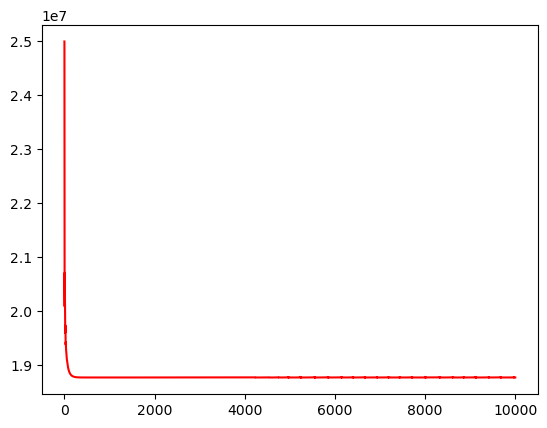

[24995202.0, 24968312.0, 22873174.0, 21082184.0, 20091606.0, 20079062.0, 20521112.0, 20705526.0, 20596556.0, 20407400.0, 20278294.0, 20231366.0, 20218322.0, 20183550.0, 20100408.0, 19974840.0, 19832534.0, 19704588.0, 19617630.0, 19587498.0, 19613250.0, 19672040.0, 19722868.0, 19726166.0, 19668592.0, 19570444.0, 19469666.0, 19398540.0, 19369732.0, 19376014.0, 19398682.0, 19417816.0, 19419868.0, 19400982.0, 19366288.0, 19326284.0, 19291878.0, 19269724.0, 19259850.0, 19256722.0, 19253146.0, 19244594.0, 19230932.0, 19215134.0, 19200488.0, 19188604.0, 19179066.0, 19170338.0, 19160990.0, 19150504.0, 19139378.0, 19128712.0, 19119476.0, 19111928.0, 19105458.0, 19098972.0, 19091554.0, 19083016.0, 19073958.0, 19065310.0, 19057776.0, 19051438.0, 19045848.0, 19040322.0, 19034382.0, 19027938.0, 19021262.0, 19014766.0, 19008764.0, 19003326.0, 18998264.0, 18993310.0, 18988268.0, 18983122.0, 18977992.0, 18973030.0, 18968322.0, 18963836.0, 18959482.0, 18955170.0, 18950868.0, 18946630.0, 18942510.0, 189

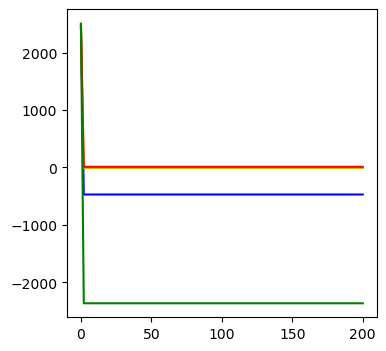

In [ ]:
# result

plt.plot(loss_list, 'r')
plt.show()
print(loss_list)




net.eval()
with torch.no_grad():
    output = net(t)
    S = output[:, 0].numpy()
    E = output[:, 1].numpy()
    I = output[:, 2].numpy()
    R = output[:, 3].numpy()

plt.figure(figsize=(4, 4))
plt.plot(t.detach().numpy(), S, 'b', label='S')
plt.plot(t.detach().numpy(), E, 'y', label='E')
plt.plot(t.detach().numpy(), I, 'r', label='I')
plt.plot(t.detach().numpy(), R, 'g', label='R')